# timesformer LDA

In [7]:
# test_ids 추출

import os
from pathlib import Path

# 데이터셋 경로 설정
ROOT = Path(r"D:\golfDataset\dataset")
TEST_ROOT = ROOT / "test"
IDS_DIR = Path(os.getcwd()).resolve() / 'ids_txt'

def collect_ids(video_dir):
    # crop_video 폴더 내 mp4 파일명만 추출 (확장자 제거)
    ids = []
    for mp4 in video_dir.glob("*.mp4"):
        ids.append(mp4.stem)
    return ids

def main():
    test_ids = []
    for cat in ['balanced_true', 'false']:
        video_dir = TEST_ROOT / cat / 'crop_video'
        if video_dir.exists():
            test_ids += collect_ids(video_dir)
    print(f"[INFO] #Test={len(test_ids)}")
    IDS_DIR.mkdir(parents=True, exist_ok=True)
    (IDS_DIR / 'test_ids.txt').write_text('\n'.join(test_ids))

if __name__ == "__main__":
    main()

[INFO] #Test=272


임베딩 shape: (2071, 768), 라벨 shape: (2071,)

[Train Evaluation]
[Train] acc=0.9771, auc=0.9976
CM:
 [[1074   39]
 [  12 1102]]
              precision    recall  f1-score   support

           0     0.9890    0.9650    0.9768      1113
           1     0.9658    0.9892    0.9774      1114

    accuracy                         0.9771      2227
   macro avg     0.9774    0.9771    0.9771      2227
weighted avg     0.9774    0.9771    0.9771      2227



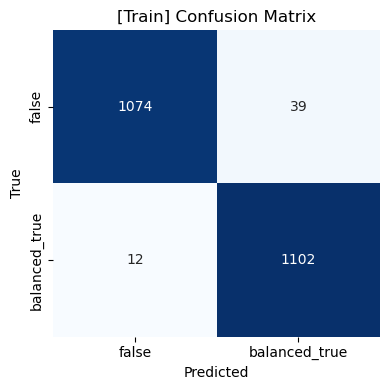


[Valid Evaluation]
[Valid] acc=0.9731, auc=0.9983
CM:
 [[268  11]
 [  4 274]]
              precision    recall  f1-score   support

           0     0.9853    0.9606    0.9728       279
           1     0.9614    0.9856    0.9734       278

    accuracy                         0.9731       557
   macro avg     0.9733    0.9731    0.9731       557
weighted avg     0.9734    0.9731    0.9731       557



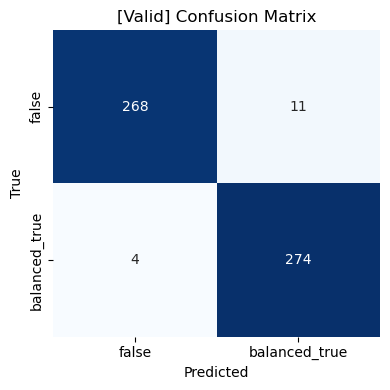


[Test Evaluation]
[Test] acc=0.4044, auc=0.3517
CM:
 [[ 31 106]
 [ 56  79]]
              precision    recall  f1-score   support

           0     0.3563    0.2263    0.2768       137
           1     0.4270    0.5852    0.4938       135

    accuracy                         0.4044       272
   macro avg     0.3917    0.4057    0.3853       272
weighted avg     0.3914    0.4044    0.3845       272



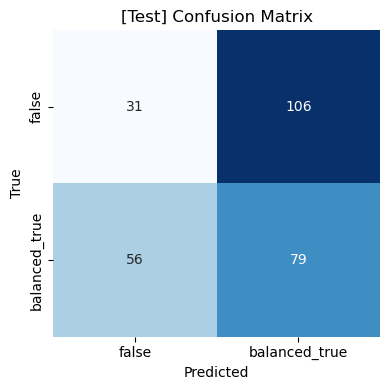

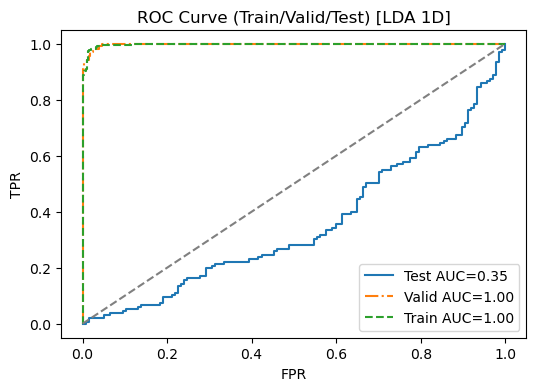

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import json

# 1. Timesformer 임베딩 및 라벨 로딩
PER_VIDEO_DIR = Path('embedding_data/timesformer/per_video')
feats = []
labels = []
vids = []
for npy_path in PER_VIDEO_DIR.glob("*.npy"):
    vid = npy_path.stem
    json_path = PER_VIDEO_DIR / f"{vid}.json"
    if not json_path.exists():
        continue
    emb = np.load(npy_path)
    with open(json_path, 'r', encoding='utf-8') as jf:
        meta = json.load(jf)
        label = meta.get('label', -1)
    feats.append(emb)
    labels.append(label)
    vids.append(vid)
feats = np.stack(feats)
labels = np.array(labels)
vids = np.array(vids)
print(f"임베딩 shape: {feats.shape}, 라벨 shape: {labels.shape}")

# 2. Train/Test 분리 (test_ids.txt 활용)
TEST_IDS_TXT = Path('ids_txt/test_ids.txt')
with open(TEST_IDS_TXT, 'r') as f:
    test_ids = set(line.strip() for line in f if line.strip())

train_idx = [i for i, vid in enumerate(vids) if vid not in test_ids]
test_idx  = [i for i, vid in enumerate(vids) if vid in test_ids]

X_train = feats[train_idx]
y_train = labels[train_idx]
X_test  = feats[test_idx]
y_test  = labels[test_idx]

# 3. 정규화 (train 기준으로 fit)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std  = scaler.transform(X_test)

# 4. LDA 변환 (train 기준으로 fit)
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
lda = LDA(n_components=1)
X_train_lda = lda.fit_transform(X_train_std, y_train)
X_test_lda  = lda.transform(X_test_std)

# 5. (선택) train/valid 분할 및 불균형 보정
from sklearn.utils import resample
from sklearn.model_selection import train_test_split

false_idx = np.where(y_train == 0)[0]
true_idx = np.where(y_train == 1)[0]
n_false = len(false_idx)
n_true = len(true_idx)
if n_false < n_true:
    X_false_upsampled, y_false_upsampled = resample(
        X_train_lda[false_idx], y_train[false_idx],
        replace=True, n_samples=n_true, random_state=42
    )
    X_train_balanced = np.concatenate([X_train_lda[true_idx], X_false_upsampled], axis=0)
    y_train_balanced = np.concatenate([y_train[true_idx], y_false_upsampled], axis=0)
else:
    X_train_balanced = X_train_lda
    y_train_balanced = y_train

X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_balanced, y_train_balanced, test_size=0.2, random_state=42, stratify=y_train_balanced
)

# 6. PyTorch 분류기 정의 및 학습
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 64
LR = 1e-4
WEIGHT_DECAY = 1e-4
RETRAIN_EPOCHS = 30
EARLY_STOP = 5

class HeadMLP1D(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, 2)
        )
    def forward(self, x):
        return self.net(x)

def train_mlp(X, y):
    model = HeadMLP1D().to(DEVICE)
    true_count = np.sum(y == 1)
    false_count = np.sum(y == 0)
    weight = torch.tensor([true_count / false_count, 1.0], dtype=torch.float32).to(DEVICE)
    crit  = nn.CrossEntropyLoss(weight=weight, label_smoothing=0.1)
    opt   = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
    ds = TensorDataset(torch.from_numpy(X).float(), torch.from_numpy(y).long())
    dl = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
    best_loss, patience = float('inf'), 0
    for epoch in range(1, RETRAIN_EPOCHS+1):
        model.train(); running = 0.0
        for xb, yb in dl:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            opt.zero_grad(); out = model(xb)
            loss = crit(out, yb); loss.backward(); opt.step()
            running += loss.item() * yb.size(0)
        avg = running / len(ds)
        if avg < best_loss:
            best_loss, patience = avg, 0
            best_state = model.state_dict()
        else:
            patience += 1
            if patience >= EARLY_STOP: break
    model.load_state_dict(best_state)
    return model

def evaluate(model, X, y, title):
    model.eval()
    with torch.no_grad():
        probs = torch.softmax(model(torch.from_numpy(X).float().to(DEVICE)), 1)[:,1].cpu().numpy()
    preds = (probs > 0.5).astype(int)
    acc = accuracy_score(y, preds)
    fpr, tpr, _ = roc_curve(y, probs)
    auc_val = auc(fpr, tpr)
    print(f"{title} acc={acc:.4f}, auc={auc_val:.4f}")
    print("CM:\n", confusion_matrix(y, preds))
    print(classification_report(y, preds, digits=4))
    return fpr, tpr, auc_val

import seaborn as sns
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['false', 'balanced_true'],
                yticklabels=['false', 'balanced_true'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.tight_layout()
    plt.show()

# 7. 학습 및 평가
model = train_mlp(X_tr, y_tr)
print("\n[Train Evaluation]")
fpr_tr, tpr_tr, auc_tr = evaluate(model, X_tr, y_tr, "[Train]")
plot_confusion_matrix(
    y_tr,
    (torch.softmax(model(torch.from_numpy(X_tr).float().to(DEVICE)), 1)[:,1].cpu().detach().numpy() > 0.5).astype(int),
    "[Train] Confusion Matrix"
)

print("\n[Valid Evaluation]")
fpr_val, tpr_val, auc_val = evaluate(model, X_val, y_val, "[Valid]")
plot_confusion_matrix(
    y_val,
    (torch.softmax(model(torch.from_numpy(X_val).float().to(DEVICE)), 1)[:,1].cpu().detach().numpy() > 0.5).astype(int),
    "[Valid] Confusion Matrix"
)

print("\n[Test Evaluation]")
fpr_te, tpr_te, auc_te = evaluate(model, X_test_lda, y_test, "[Test]")
plot_confusion_matrix(
    y_test,
    (torch.softmax(model(torch.from_numpy(X_test_lda).float().to(DEVICE)), 1)[:,1].cpu().detach().numpy() > 0.5).astype(int),
    "[Test] Confusion Matrix"
)

# 8. ROC Curve 시각화
plt.figure(figsize=(6,4))
plt.plot(fpr_te, tpr_te, label=f"Test AUC={auc_te:.2f}")
plt.plot(fpr_val, tpr_val, label=f"Valid AUC={auc_val:.2f}", linestyle='-.')
plt.plot(fpr_tr, tpr_tr, label=f"Train AUC={auc_tr:.2f}", linestyle='--')
plt.plot([0,1],[0,1],'--', color='gray')
plt.title("ROC Curve (Train/Valid/Test) [LDA 1D]")
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.legend();

임베딩 shape: (2071, 768), 라벨 shape: (2071,)


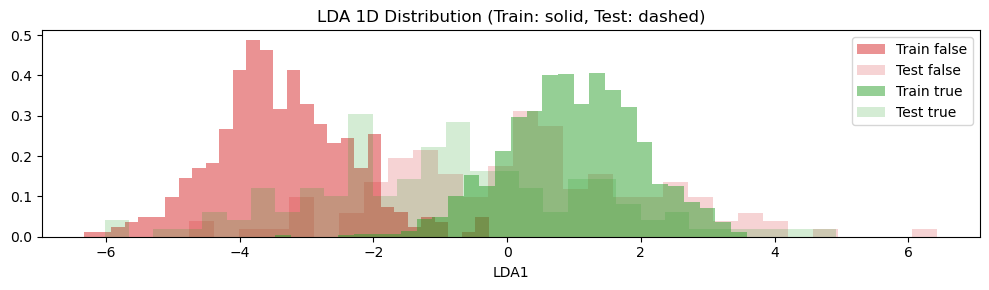

Text(0.5, 1.0, 'LDA 1D Distribution (Test Only)')

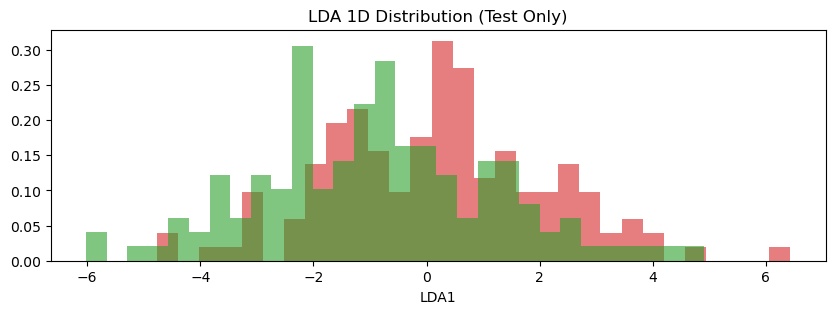

In [3]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import json

# 1. Timesformer 임베딩 및 라벨 로딩
PER_VIDEO_DIR = Path('embedding_data/timesformer/per_video')
feats = []
labels = []
vids = []
for npy_path in PER_VIDEO_DIR.glob("*.npy"):
    vid = npy_path.stem
    json_path = PER_VIDEO_DIR / f"{vid}.json"
    if not json_path.exists():
        continue
    emb = np.load(npy_path)
    with open(json_path, 'r', encoding='utf-8') as jf:
        meta = json.load(jf)
        label = meta.get('label', -1)
    feats.append(emb)
    labels.append(label)
    vids.append(vid)
feats = np.stack(feats)
labels = np.array(labels)
vids = np.array(vids)
print(f"임베딩 shape: {feats.shape}, 라벨 shape: {labels.shape}")

# 2. Train/Test 분리 (test_ids.txt 활용)
TEST_IDS_TXT = Path('ids_txt/test_ids.txt')
with open(TEST_IDS_TXT, 'r') as f:
    test_ids = set(line.strip() for line in f if line.strip())

train_idx = [i for i, vid in enumerate(vids) if vid not in test_ids]
test_idx  = [i for i, vid in enumerate(vids) if vid in test_ids]

X_train = feats[train_idx]
y_train = labels[train_idx]
X_test  = feats[test_idx]
y_test  = labels[test_idx]

# 3. 정규화 (train 기준으로 fit)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std  = scaler.transform(X_test)

# 4. LDA 변환 (train 기준으로 fit)
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
lda = LDA(n_components=1)
X_train_lda = lda.fit_transform(X_train_std, y_train)
X_test_lda  = lda.transform(X_test_std)

# 5. 시각화 (train/test 분포)
plt.figure(figsize=(10,3))
for label, color, name in zip([0,1], ['tab:red','tab:green'], ['false','true']):
    plt.hist(X_train_lda[y_train==label], bins=30, color=color, label=f"Train {name}", alpha=0.5, density=True)
    plt.hist(X_test_lda[y_test==label], bins=30, color=color, label=f"Test {name}", alpha=0.2, density=True, histtype='stepfilled', linestyle='dashed')
plt.xlabel('LDA1')
plt.title('LDA 1D Distribution (Train: solid, Test: dashed)')
plt.legend()
plt.tight_layout()
plt.show()

# --- test 데이터만 시각화 ---
plt.figure(figsize=(10,3))
for label, color, name in zip([0,1], ['tab:red','tab:green'], ['false','true']):
    plt.hist(X_test_lda[y_test==label], bins=30, color=color, label=f"Test {name}", alpha=0.6, density=True)
plt.xlabel('LDA1')
plt.title('LDA 1D Distribution (Test Only)')